In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import svm
import itertools

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [48]:
data1 = pd.read_csv("phising.data", header=None)
data = data1.values.astype(float)     # Convert from pandas dataframe to numpy

X_main = data[:,:-1]
y_main = data[:,-1]

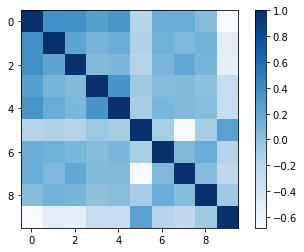

In [49]:
plt.imshow(data1.corr(), cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
#plt.savefig('destination_path.eps', format='eps', dpi=400)

In [50]:
data1.corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.375943,0.368690,0.257247,0.333703,-0.187082,0.151503,0.163182,0.043349,-0.678277
1,0.375943,1.000000,0.218050,0.111520,0.167760,-0.140407,0.136229,0.076815,0.123399,-0.509749
2,0.368690,0.218050,1.000000,0.057239,0.088525,-0.171719,0.095055,0.208091,0.108000,-0.518762
3,0.257247,0.111520,0.057239,1.000000,0.337277,-0.045858,0.048431,0.053348,0.013346,-0.271609
4,0.333703,0.167760,0.088525,0.337277,1.000000,-0.092045,0.097581,0.069178,0.039412,-0.287007
5,-0.187082,-0.140407,-0.171719,-0.045858,-0.092045,1.000000,-0.108204,-0.683857,-0.094957,0.243896
6,0.151503,0.136229,0.095055,0.048431,0.097581,-0.108204,1.000000,0.075338,0.165152,-0.183061
7,0.163182,0.076815,0.208091,0.053348,0.069178,-0.683857,0.075338,1.000000,0.040379,-0.231931
8,0.043349,0.123399,0.108000,0.013346,0.039412,-0.094957,0.165152,0.040379,1.000000,-0.059225
9,-0.678277,-0.509749,-0.518762,-0.271609,-0.287007,0.243896,-0.183061,-0.231931,-0.059225,1.000000


In [62]:
# SVM using all the features

clf = None
y_ = None
y_test = None
kf = KFold(n_splits=10)
kf.get_n_splits(X)
avg=0
for train_index, test_index in kf.split(X_main):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = svm.SVC()#gamma='scale', decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score",avg/10)

0.8455882352941176
0.8308823529411765
0.8529411764705882
0.8814814814814815
0.8592592592592593
0.9037037037037037
0.7925925925925926
0.8740740740740741
0.8888888888888888
0.8518518518518519
Final average score 0.8581263616557733


Normalized confusion matrix
[[0.92857143 0.01428571 0.05714286]
 [0.25       0.16666667 0.58333333]
 [0.09433962 0.         0.90566038]]


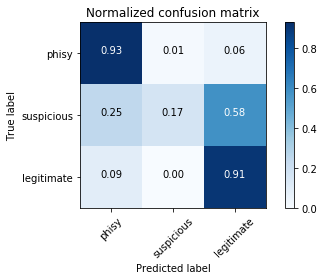

In [67]:
from sklearn.metrics import confusion_matrix
class_names = []
cnf_matrix = confusion_matrix(y_test, y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['phisy', 'suspicious', 'legitimate'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('conf_svm.eps', format='eps', dpi=400)
plt.show()


In [64]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y = label_binarize(y_test, classes=[-1, 0, 1])
y_score = label_binarize(y_, classes=[-1, 0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

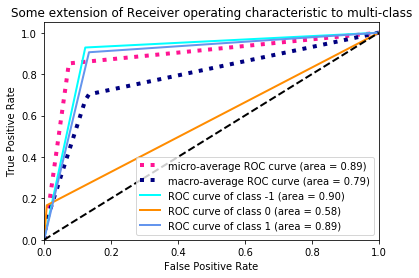

In [66]:
# Compute macro-average ROC curve and ROC area
from itertools import cycle


n_classes = 3
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc_svm.eps', format='eps', dpi=400)
plt.show()


In [55]:
from sklearn.metrics import f1_score

print(f1_score(y_test, y_, average='macro'))

0.6776334776334777


In [56]:
boo = (y_ == 2)
for i in range(y_.shape[0]):
    if y_test[i]==-1 and y_[i]==-1:
        boo[i] = True
print(np.sum(boo), np.sum(y_test==-1))
print(np.sum(y_==0), np.sum(y_test==0))
print(np.sum(y_==1), np.sum(y_test==1))

65 70
3 12
59 53


In [57]:
# SVM using only selected features that is from column 1-6

clf = None
X_ = X_main[:,:6]
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
avg=0
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = svm.SVC()#gamma='scale', decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score",avg/10)

0.8382352941176471
0.8308823529411765
0.8455882352941176
0.8962962962962963
0.8666666666666667
0.9037037037037037
0.7851851851851852
0.9037037037037037
0.8740740740740741
0.8444444444444444
Final average score 0.8588779956427015


In above application of Multi-class classification using SVM. Observe that as correlation is less for all columns after 6th column we discard all those and accuracy is nearly equal and actually slightly greater. This is as been proved that noise actually increase our classification error.

In [58]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf = None
y_ = None
y_test = None
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
avg=0
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score 6 features",avg/10)

print()

kf = KFold(n_splits=10)
kf.get_n_splits(X)
avg=0
for train_index, test_index in kf.split(X):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score all features",avg/10)

0.75
0.7794117647058824
0.8308823529411765
0.8296296296296296
0.8518518518518519
0.8444444444444444
0.7925925925925926
0.8074074074074075
0.8222222222222222
0.7851851851851852
Final average score 6 features 0.8093627450980392

0.7794117647058824
0.7720588235294118
0.8014705882352942
0.8148148148148148
0.8518518518518519
0.8518518518518519
0.8
0.8074074074074075
0.8518518518518519
0.8
Final average score all features 0.8130718954248367


Normalized confusion matrix
[[0.87142857 0.         0.12857143]
 [0.33333333 0.16666667 0.5       ]
 [0.11320755 0.03773585 0.8490566 ]]


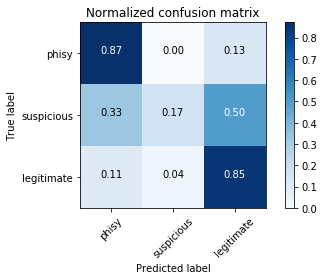

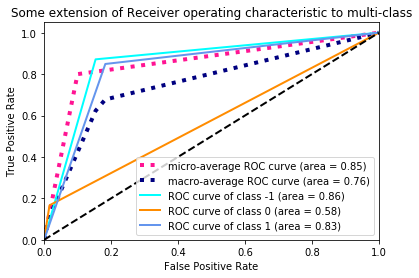

0.6372361346471683


In [61]:
from sklearn.metrics import confusion_matrix
class_names = []
cnf_matrix = confusion_matrix(y_test, y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['phisy', 'suspicious', 'legitimate'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('conf_naivebayes.eps', format='eps', dpi=400)
plt.show()

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y = label_binarize(y_test, classes=[-1, 0, 1])
y_score = label_binarize(y_, classes=[-1, 0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
from itertools import cycle


n_classes = 3
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc_naivebayes.eps', format='eps', dpi=400)
plt.show()


from sklearn.metrics import f1_score

print(f1_score(y_test, y_, average='macro'))

In [68]:
# Decision Trees
from sklearn import tree

clf = None
y_ = None
y_test = None
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
avg=0
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score 6 features",avg/10)

print()
kf = KFold(n_splits=10)
kf.get_n_splits(X)
avg=0
for train_index, test_index in kf.split(X_main):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    #print(clf.feature_importances_)
    

print("Final average score all features",avg/10)

0.8382352941176471
0.8529411764705882
0.875
0.9111111111111111
0.8740740740740741
0.8444444444444444
0.8222222222222222
0.8518518518518519
0.8666666666666667
0.8666666666666667
Final average score 6 features 0.8603213507625271

0.8602941176470589
0.8235294117647058
0.8823529411764706
0.9185185185185185
0.9037037037037037
0.8888888888888888
0.8888888888888888
0.8592592592592593
0.8962962962962963
0.8666666666666667
Final average score all features 0.8788398692810457


Normalized confusion matrix
[[0.88571429 0.02857143 0.08571429]
 [0.25       0.75       0.        ]
 [0.11320755 0.01886792 0.86792453]]


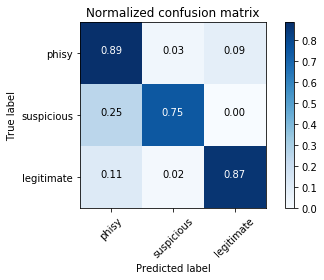

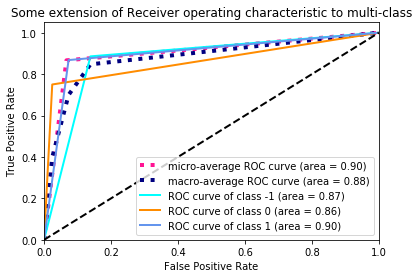

0.8352077001013171


In [69]:
from sklearn.metrics import confusion_matrix
class_names = []
cnf_matrix = confusion_matrix(y_test, y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['phisy', 'suspicious', 'legitimate'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('conf_dtrees.eps', format='eps', dpi=400)
plt.show()

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y = label_binarize(y_test, classes=[-1, 0, 1])
y_score = label_binarize(y_, classes=[-1, 0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
from itertools import cycle


n_classes = 3
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc_dtrees.eps', format='eps', dpi=400)
plt.show()


from sklearn.metrics import f1_score

print(f1_score(y_test, y_, average='macro'))

In [70]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = None
y_ = None
y_test = None
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
avg=0
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score only 6 features",avg/10)

print()

kf = KFold(n_splits=10)
kf.get_n_splits(X)
avg=0
for train_index, test_index in kf.split(X):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score taking all features",avg/10)

/home/singh/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.8529411764705882
0.8529411764705882
0.875
0.9111111111111111
0.8518518518518519
0.8888888888888888
0.837037037037037
0.8814814814814815
0.8666666666666667
0.8666666666666667
Final average score only 6 features 0.8684586056644881

0.875
0.8602941176470589
0.8897058823529411
0.8962962962962963
0.9111111111111111
0.8888888888888888
0.8444444444444444
0.8962962962962963
0.8962962962962963
0.8740740740740741
Final average score taking all features 0.8832407407407408


Normalized confusion matrix
[[0.87142857 0.01428571 0.11428571]
 [0.16666667 0.75       0.08333333]
 [0.0754717  0.01886792 0.90566038]]


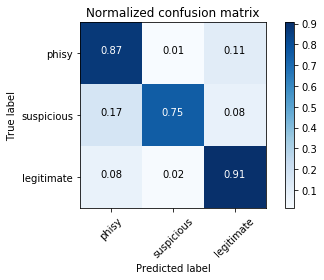

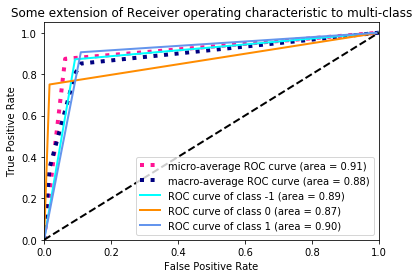

0.8486156390948519


In [71]:
from sklearn.metrics import confusion_matrix
class_names = []
cnf_matrix = confusion_matrix(y_test, y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['phisy', 'suspicious', 'legitimate'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('conf_rforest.eps', format='eps', dpi=400)
plt.show()

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y = label_binarize(y_test, classes=[-1, 0, 1])
y_score = label_binarize(y_, classes=[-1, 0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
from itertools import cycle


n_classes = 3
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc_rforest.eps', format='eps', dpi=400)
plt.show()


from sklearn.metrics import f1_score

print(f1_score(y_test, y_, average='macro'))

In [72]:
#MLP

from sklearn.neural_network import MLPClassifier

clf = None
y_ = None
y_test = None
kf = KFold(n_splits=10)
kf.get_n_splits(X_)
avg=0
for train_index, test_index in kf.split(X_):
    X_train, X_test = X_[train_index], X_[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score only 6 features",avg/10)

print()

kf = KFold(n_splits=10)
kf.get_n_splits(X)
avg=0
for train_index, test_index in kf.split(X):
    X_train, X_test = X_main[train_index], X_main[test_index]
    y_train, y_test = y_main[train_index], y_main[test_index]
    
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    clf.fit(X_train, y_train)
    
    y_ = clf.predict(X_test)
    
    acc = accuracy_score(y_, y_test)
    avg+= acc
    print(acc)
    
print("Final average score taking all features",avg/10)

0.8308823529411765
0.8088235294117647
0.8161764705882353
0.8888888888888888
0.8444444444444444
0.9111111111111111
0.7851851851851852
0.9037037037037037
0.8666666666666667
0.837037037037037
Final average score only 6 features 0.8492919389978214

0.8308823529411765
0.8235294117647058
0.8382352941176471
0.8814814814814815
0.8592592592592593
0.9111111111111111
0.8
0.8814814814814815
0.8592592592592593
0.8518518518518519
Final average score taking all features 0.8537091503267973


Normalized confusion matrix
[[0.94285714 0.         0.05714286]
 [0.33333333 0.         0.66666667]
 [0.0754717  0.         0.9245283 ]]


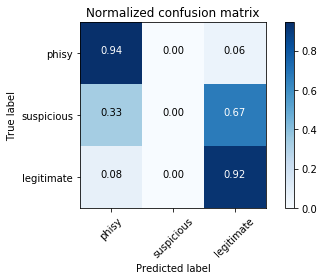

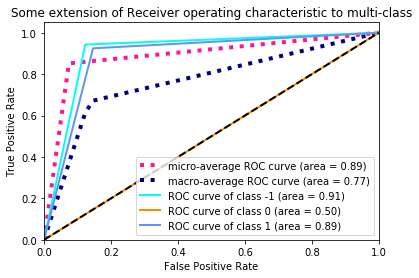

0.5921052631578948


/home/singh/anaconda3/envs/data/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
from sklearn.metrics import confusion_matrix
class_names = []
cnf_matrix = confusion_matrix(y_test, y_)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['phisy', 'suspicious', 'legitimate'], normalize=True,
                      title='Normalized confusion matrix')

#plt.savefig('conf_mlp.eps', format='eps', dpi=400)
plt.show()

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y = label_binarize(y_test, classes=[-1, 0, 1])
y_score = label_binarize(y_, classes=[-1, 0, 1])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# Compute macro-average ROC curve and ROC area
from itertools import cycle


n_classes = 3
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i-1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
#plt.savefig('roc_mlp.eps', format='eps', dpi=400)
plt.show()


from sklearn.metrics import f1_score

print(f1_score(y_test, y_, average='macro'))